In [1]:
!pip install openai langchain chromadb umap-learn pypdf matplotlib sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.5 MB/s eta 0:00:00


In [2]:
from openai import OpenAI
import openai
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
from pypdf import PdfReader
import os
import umap
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer

In [4]:
# Load environment variables from .env file (API keys, etc.)
load_dotenv()

# Set up OpenAI API key - add on your own .env file with OPEN API Key
openai_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=openai_key)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [5]:
# Read and extract text from a PDF
reader = PdfReader("./microsoft-annual-report.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]
pdf_texts = [text for text in pdf_texts if text]

# Split the text into manageable chunks
character_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

# Print a sample chunk
split_texts[:2]

FileNotFoundError: [Errno 2] No such file or directory: './microsoft-annual-report.pdf'

In [6]:
# Initialize Chroma client and SentenceTransformer for embeddings
embedding_function = SentenceTransformerEmbeddingFunction()
chroma_client = chromadb.Client()

# Create or get a collection in Chroma
collection = chroma_client.create_collection("microsoft-report7", embedding_function=embedding_function)

# Add documents to Chroma and create unique IDs for each chunk
ids = [str(i) for i in range(len(split_texts))]  #
collection.add(ids=ids, documents=split_texts)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

NameError: name 'split_texts' is not defined

In [36]:
def generate_multiple_expanded_queries(query, n=3):
    """
    Generate multiple expanded queries for a given input query.

    Args:
        query (str): The original user query.
        n (int): Number of expanded queries to generate.

    Returns:
        List[str]: A list of expanded queries.
    """
    expanded_queries = []
    for i in range(n):
        prompt = f"""
        You are a financial analyst assistant. For the user query:
        '{query}', generate an expanded query (variant {i + 1}) that provides additional context or perspective.
        """
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You generate contextual documents for queries."},
                {"role": "user", "content": prompt},
            ],
        )
        expanded_queries.append(response.choices[0].message.content.strip())
    return expanded_queries

In [38]:
def retrieve_documents(collection, query_texts, n_results=5):
    """
    Retrieve documents for a list of queries.

    Args:
        collection: The Chroma collection object.
        query_texts (List[str]): List of queries (original + expanded).
        n_results (int): Number of results to retrieve per query.

    Returns:
        dict: Combined results with document texts and embeddings.
    """
    all_results = {"documents": [], "embeddings": []}
    for query in query_texts:
        results = collection.query(query_texts=[query], n_results=n_results, include=["documents", "embeddings"])
        all_results["documents"].extend(results["documents"])
        all_results["embeddings"].extend(results["embeddings"])
    return all_results

In [65]:
def aggregate_results(query_embedding, document_embeddings, documents):
    """
    Aggregate results by calculating cosine similarity and ranking documents.

    Args:
        query_embedding (np.array): Embedding of the combined query.
        document_embeddings (List[np.array]): Embeddings of retrieved documents.
        documents (List[str]): List of document texts.

    Returns:
        List[Tuple[str, float]]: Ranked documents with similarity scores.
    """
    similarities = cosine_similarity([query_embedding], document_embeddings)[0]
    ranked_results = sorted(zip(documents, similarities), key=lambda x: x[1], reverse=True)
    return ranked_results

# Initialize model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define the original query
original_query = "Give me a breakdown of liabilities and stockholders' equity"


In [66]:
#Without Query Expansion
original_query_results = retrieve_documents(collection, [original_query], n_results=5)
original_query_embedding = model.encode([original_query])[0]
ranked_original_results = aggregate_results(
    original_query_embedding,
    model.encode(original_query_results["documents"]),
    original_query_results["documents"]
)
#With Query Expansion
expanded_queries = generate_multiple_expanded_queries(original_query, n=3)
query_texts = [original_query] + expanded_queries
expanded_query_results = retrieve_documents(collection, query_texts, n_results=5)

**Evalute Model Performance using Cosine Similarity Score**

In [67]:
# Combine embeddings of original and expanded queries
all_query_embeddings = [model.encode([original_query])[0]] + [model.encode([q])[0] for q in expanded_queries]
combined_query_embedding = np.mean(all_query_embeddings, axis=0)

# Rank results using combined query embedding
ranked_expanded_results = aggregate_results(
    combined_query_embedding,
    model.encode(expanded_query_results["documents"]),
    expanded_query_results["documents"]
)

# Output results
print("\n**Without Query Expansion:**")
for doc, score in ranked_original_results[:5]:
    print(f"Score: {score:.4f}\nDocument: {doc}\n")

print("\n**With Query Expansion:**")
for doc, score in ranked_expanded_results[:5]:
    print(f"Score: {score:.4f}\nDocument: {doc}\n")



**Without Query Expansion:**
Score: 0.7323
Document: ['Refer to accompanying notes.  \n  \nOperating lease liabilities  12,728  11,489 \nOther long-term liabilities  17,981  15,526 \n  \nTotal liabilities  205,753  198,298 \n  \nCommitments and contingencies   \nStockholders’ equity:   \nCommon stock and paid-in capital – shares authorized 24,000; outstanding 7,432 \nand 7,464  93,718  86,939 \nRetained earnings  118,848  84,281 \nAccumulated other comprehensive loss  (6,343 )  (4,678 )\n  \nTotal stockholders’ equity  206,223  166,542 \n  \nTotal liabilities and stockholders’ equity $ 411,976 $ 364,840 \n   \n(In millions)   \n52\n\nCASH FLOWS STATEMENTS  \n  \n53', 'STOCKHOLDERS’ EQUITY STATEMENTS  \n  \nRefer to accompanying notes.  \n  \n(In millions, except per share amounts)    \n \n    \nYear Ended June 30, 2023 2022 2021\n    \nCommon stock and paid-in capital    \nBalance, beginning of period $ 86,939 $ 83,111 $ \u2002\u200480,552 \nCommon stock issued  1,866  1,841  1,963 \n

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


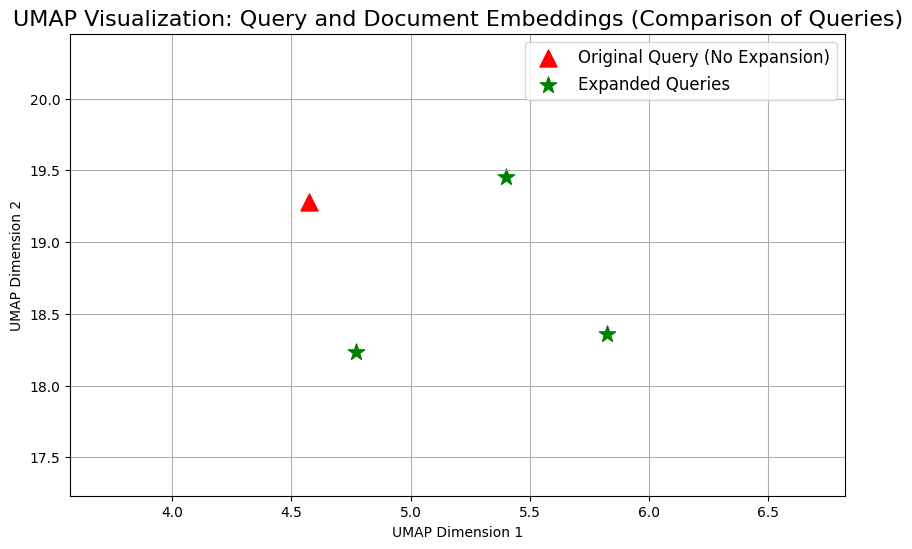

In [55]:
# UMAP Visualization: Enhanced for Query Comparison
all_embeddings = model.encode(expanded_query_results["documents"]) + all_query_embeddings
umap_transformer = umap.UMAP(n_components=2)
umap_embeddings = umap_transformer.fit_transform(all_embeddings)

# Separate embeddings for documents, original query, and expanded queries
umap_documents = umap_embeddings[:-len(all_query_embeddings)]
umap_original_query = umap_embeddings[-len(all_query_embeddings)]  # First query is original
umap_expanded_queries = umap_embeddings[-len(all_query_embeddings) + 1:]  # Remaining are expanded queries

# Plot embeddings
plt.figure(figsize=(10, 6))
# plt.scatter(umap_documents[:, 0], umap_documents[:, 1], color="blue", label="Documents", alpha=0.6)
plt.scatter(
    umap_original_query[0], umap_original_query[1],
    color="red", marker="^", label="Original Query (No Expansion)", s=150
)
plt.scatter(
    umap_expanded_queries[:, 0], umap_expanded_queries[:, 1],
    color="green", marker="*", label="Expanded Queries", s=150
)

# Adjust axis limits to zoom out
plt.xlim(np.min(umap_embeddings[:, 0]) - 1, np.max(umap_embeddings[:, 0]) + 1)
plt.ylim(np.min(umap_embeddings[:, 1]) - 1, np.max(umap_embeddings[:, 1]) + 1)

# Add titles and legends
plt.legend(fontsize=12)
plt.title("UMAP Visualization: Query and Document Embeddings (Comparison of Queries)", fontsize=16)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()